# Requirements
* bedtools
* pybedtools
* numpy
* tensorflow
* keras
* sklearn
* matplotlib

# Data Source
* Downloading data form https://www.ncbi.nlm.nih.gov/geo/
* NHEK_Dnase.bed: GSM736556_hg19_wgEncodeUwDnaseNhekHotspotsRep2.broadPeak.gz
* NHEK_CTCF.bed: GSM733636_hg19_wgEncodeBroadHistoneNhekCtcfStdPk.broadPeak.gz
* NHEK_p63.bed: GSM1446927_HKC_L1_ChIP_p63_day0_peaks.txt.gz
* NHEK_H3K4me1.bed: GSM733698_hg19_wgEncodeBroadHistoneNhekH3k4me1StdPk.broadPeak.gz
* NHEK_DSB.bed: GSE78172_NHEK.tar.gz
### These files are in the Data fold.

In [1]:
# convert data to 1 kb
import os
from thousand import thousand

datafiles = os.listdir('Data')
os.mkdir('Data1kb')

for file in datafiles:
    outdatafile = open('Data1kb/' + file.split('.')[0] + '_1kb.bed', 'w')
    outlist = []
    for line in open('Data/' + file):
        chrom, start, stop = line.split()
        start, stop = int(start), int(stop)
        start, stop = thousand(start, stop)
        outline = (chrom, str(start), str(stop))
        outlist.append('\t'.join(outline))
    for line in outlist:
        outdatafile.write(line + '\n')
    #print(file, 'is converted to 1 kb.')
    outdatafile.close()

In [2]:
# generate the negative DSB file
import pybedtools
import random

inputpos = pybedtools.BedTool('Data/NHEK_DSB.bed')
inputpos = inputpos.sort()
comple = inputpos.complement(g = 'hg19_sorted.genome')
comple.saveas('DSBcomple.bed')

with open('DSBcomple.bed') as f:
    comple = f.readlines()
    length = len(comple)
    i = 1
    list = []
    while i<100001:
        index = random.randint(0, length-1)
        chrom, start, stop = comple[index].split()
        start, stop = int(start), int(stop)
        interval = stop-start
        if interval < 999:
            continue
        else:
            i = i + 1
            r = random.randint(start, stop-999)
            negstart = start+r
            negstop = negstart + 1000
            bed = (chrom, str(negstart), str(negstop))
            list.append('\t'.join(bed))

outfile = open('Data1kb/NHEK_NegDSB_1kb.bed', 'w')

for outline in list:
    outfile.write(outline + '\n')
#print('Negative DSB file is generated.')
outfile.close()

In [3]:
# mark DSB with epigenome data
epifiles = ('NHEK_Dnase_1kb.bed', 'NHEK_CTCF_1kb.bed', 
           'NHEK_p63_1kb.bed', 'NHEK_H3K4me1_1kb.bed')
breakfiles = ('NHEK_DSB_1kb.bed', 'NHEK_NegDSB_1kb.bed')

os.mkdir('DSBepi')

for bfile in breakfiles:
    for efile in epifiles:
        outfile = 'DSBepi/' + bfile.split('_')[1] + '_' + efile.split('_')[1] + '.bed'
        bbed = pybedtools.BedTool('Data1kb/' + bfile)
        ebed = pybedtools.BedTool('Data1kb/' + efile)
        ibed = bbed.intersect(ebed)
        ibed = ibed.sort()
        ibed.saveas(outfile)

In [4]:
# generate the input file
import numpy as np

DSBepifiles = os.listdir('DSBepi')

os.mkdir('inputfiles')

for bfile in breakfiles:
    for efile in DSBepifiles:
        if bfile.split('_')[1] == efile.split('_')[0]:
            b = open('Data1kb/' + bfile)
            e = open('DSBepi/' + efile)
            #print(bfile, efile)
            blist = b.readlines()
            elist = e.readlines()
            ej = 0
            m = np.zeros(shape=(len(blist), 1000))
            for i in range(0, len(blist)):
                bchrom, bstart, bstop = blist[i].split()
                bstart, bstop = int(bstart), int(bstop)
                for j in range(ej, len(elist)):
                    echrom, estart, estop = elist[j].split()
                    estart, estop = int(estart), int(estop)
                    if bchrom == echrom and estop <= bstop:
                        m[i][estart-bstart:estop-bstart] = 1
                        ej = ej +1
                    else:
                        break

            b.close
            e.close
            #print(m.shape)
            outfile = 'inputfiles/' + efile.split('.')[0]
            m = m.astype(np.int8)
            np.save(outfile, m)

In [6]:
# training
import gc
import numpy as np
import os
import random

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

x1 = np.load('inputfiles/DSB_Dnase.npy')
x2 = np.load('inputfiles/DSB_CTCF.npy')
x3 = np.load('inputfiles/DSB_p63.npy')
x4 = np.load('inputfiles/DSB_H3K4me1.npy')
x = np.concatenate((x1, x2, x3, x4), axis=1)
del x1, x2, x3, x4
gc.collect()
print(x.shape)

x5 = np.load('inputfiles/NegDSB_Dnase.npy')
x6 = np.load('inputfiles/NegDSB_Dnase.npy')
x7 = np.load('inputfiles/NegDSB_Dnase.npy')
x8 = np.load('inputfiles/NegDSB_Dnase.npy')
xneg = np.concatenate((x5, x6, x7, x8), axis = 1)
del x5, x6, x7, x8
gc.collect()
print(xneg.shape)

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

model = Sequential()
model.add(Conv1D(32, 8, activation='relu', input_shape=(1000,4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 8, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 4, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

x = x.reshape(84946, 4, 1000)
xneg = xneg.reshape(100000, 4, 1000)
y1 = np.ones(84946)
y2 = np.zeros(100000)
x = np.append(x,xneg,axis=0)
y = np.append(y1,y2,axis=0)
index = [i for i in range(len(x))]
random.shuffle(index)
x = x[index]
y = y[index]
del xneg, y1, y2
gc.collect()

x = x.transpose(0, 2, 1)
x_train = x[:150000].astype('float32')
x_test = x[150000:].astype('float32')
del x
gc.collect()

y_train = y[:150000].astype('float32')
y_test = y[150000:].astype('float32')
del y
gc.collect()

history = model.fit(x_train, y_train, epochs=2, batch_size=128, validation_split=0.2)

(84946, 4000)
(100000, 4000)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 993, 32)           1056      
_________________________________________________________________
batch_normalization_4 (Batch (None, 993, 32)           128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 496, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 489, 32)           8224      
_________________________________________________________________
batch_normalization_5 (Batch (None, 489, 32)           128       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 244, 32)           0         
_________________________________________________________________
conv1d_6 (Conv1D)        

34946/34946 [==============================] - 27s 785us/step


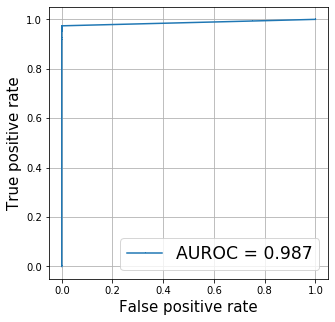

In [7]:
# prediction
from sklearn import metrics
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline

y_pred = model.predict(x_test, verbose = 1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
AUC = auc(fpr, tpr)
#print(AUC)
font = {'size': 15}
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,marker = ',',label='AUROC = %0.3f' % AUC)
plt.legend(loc=4, fontsize='xx-large')
plt.xlabel('False positive rate', font)
plt.ylabel('True positive rate', font)
plt.grid(True)

plt.show()